## Importaciones e instalaciones

In [8]:
%pip install ucimlrepo
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd # type: ignore
from ucimlrepo import fetch_ucirepo # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # type: ignore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
import numpy as np # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.svm import SVC # type: ignore



## Preprocesamiento de los datos

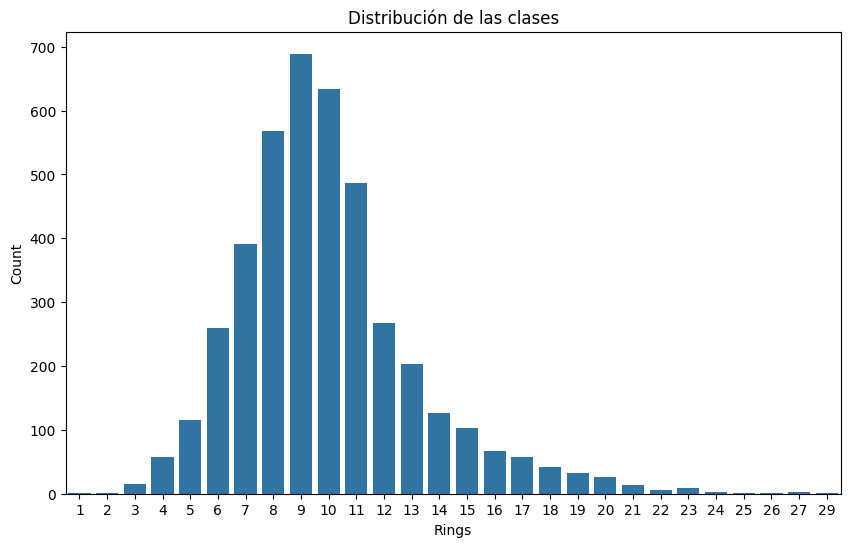

,Rings
0,15
1,7
2,9
3,10
4,7
...,...
4172,11
4173,10
4174,9
4175,10


In [11]:
#Carga de datos
abalone = fetch_ucirepo(id=1)
X = abalone.data.features
y = abalone.data.targets

#Verificamos la distribucion de clases ya que esta influir en el rendimiento del modelo
data = pd.concat([X, pd.DataFrame(y, columns=['Rings'])], axis=1)
plt.figure(figsize=(10, 6))
sns.countplot(x='Rings', data=data)
plt.title('Distribución de las clases')
plt.xlabel('Rings')
plt.ylabel('Count')
plt.show()
y


## Raw data(not filtered)

In [12]:
data_preprocessed_features = X.copy()
data_preprocessed_features = pd.get_dummies(data_preprocessed_features, columns=['Sex'], dtype=int)
data_preprocessed_features

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,1,0
...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1,0,0


## Raw data(only low correlation features)

In [14]:
data_preprocessed_features_lowCorr = X.copy()

data_preprocessed_features_lowCorr.drop(['Length','Viscera_weight','Diameter','Height','Whole_weight','Sex'],axis=1, inplace=True)
data_preprocessed_features_lowCorr

,Shucked_weight,Shell_weight
0,0.2245,0.1500
1,0.0995,0.0700
2,0.2565,0.2100
3,0.2155,0.1550
4,0.0895,0.0550
...,...,...
4172,0.3700,0.2490
4173,0.4390,0.2605
4174,0.5255,0.3080
4175,0.5310,0.2960


### Eliminamos cualquier fila cuyo numero de rings no aparezca almenos 100 veces en el dataset

In [15]:

y_counts = data['Rings'].value_counts()
filtered_indices = y_counts[y['Rings'].value_counts() >= 100].index
filtered_X = X.loc[y.index[y['Rings'].isin(filtered_indices)]]
filtered_y = y.loc[y['Rings'].isin(filtered_indices)]
print(filtered_y['Rings'].value_counts())
filtered_y


9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
Name: Rings, dtype: int64


,Rings
0,15
1,7
2,9
3,10
4,7
...,...
4172,11
4173,10
4174,9
4175,10


### Pairplot: Verificamos la dispersion de las caracteristicas para ver como se separan en el espacio y la correlacion que poseen unas con otras

In [17]:
plt.figure(figsize=(12, 8))
data = pd.concat([filtered_X, pd.DataFrame(filtered_y, columns=['Rings'])], axis=1)
sns.pairplot(data=data, hue='Rings', palette='viridis')
plt.suptitle('Dispersión de las características')
plt.show()

NameError: name 'filtered_X' is not defined

<Figure size 1200x800 with 0 Axes>

## Data y cols seleccionadas


In [31]:
X_selected = filtered_X[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']]
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_selected, filtered_y, test_size=0.2, random_state=0)

## Modelo KNN

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Definir los rangos para agrupar 'Rings'
def group_rings(ring):
    if ring <= 7:
        return 0
    elif ring <= 11:
        return 1
    elif ring <= 15:
        return 2
    else:
        return 3

# Aplicar la función a 'y' para agrupar los valores
y_grouped = y['Rings'].apply(group_rings)

# Split de datos
X_svc = data_preprocessed_features_lowCorr
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_grouped, test_size=0.3, random_state=40)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svc)
X_test_scaled = scaler.transform(X_test_svc)

# Entrenar el modelo KNN con validación cruzada
model = KNeighborsClassifier(n_neighbors=24)
scores = cross_val_score(model, X_train_scaled, y_train_svc, cv=3)

print("Cross-validated Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

print('------------------------------------------------------------')

model.fit(X_train_scaled, y_train_svc)
y_pred = model.predict(X_test_scaled)

# Calcular métricas de rendimiento
accuracy = accuracy_score(y_test_svc, y_pred)
precision = precision_score(y_test_svc, y_pred, average='macro')
recall = recall_score(y_test_svc, y_pred, average='macro')
f1_score_svc = f1_score(y_test_svc, y_pred, average='macro')

# Imprimir métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1_score_svc)

Cross-validated Scores: [0.67589744 0.67043121 0.68069815]
Mean CV Accuracy: 0.6756755997823759
------------------------------------------------------------
Accuracy: 0.6634768740031898
Precision: 0.5769497939990355
Recall: 0.4991409695077996
F1_score: 0.5061999608339052


## RNA

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Definir los rangos para agrupar 'Rings'
def group_rings(ring):
    if ring <= 7:
        return 0
    elif ring <= 11:
        return 1
    elif ring <= 15:
        return 2
    else:
        return 3

# Aplicar la función a 'y' para agrupar los valores
y_grouped = y['Rings'].apply(group_rings)

# Split de datos
X_svc = data_preprocessed_features_lowCorr
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_grouped, test_size=0.3, random_state=40)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svc)
X_test_scaled = scaler.transform(X_test_svc)

# Entrenar la RNA con validación cruzada
model = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=500, random_state=40)
scores = cross_val_score(model, X_train_scaled, y_train_svc, cv=3)

print("Cross-validated Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

print('------------------------------------------------------------')

model.fit(X_train_scaled, y_train_svc)
y_pred = model.predict(X_test_scaled)

# Calcular métricas de rendimiento
accuracy = accuracy_score(y_test_svc, y_pred)
precision = precision_score(y_test_svc, y_pred, average='macro')
recall = recall_score(y_test_svc, y_pred, average='macro')
f1_score_svc = f1_score(y_test_svc, y_pred, average='macro')

# Imprimir métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1_score_svc)

Cross-validated Scores: [0.68102564 0.70328542 0.69404517]
Mean CV Accuracy: 0.6927854121693957
------------------------------------------------------------
Accuracy: 0.6881977671451356
Precision: 0.6011533608752845
Recall: 0.5140867219296655
F1_score: 0.5276307126316373


## Porque es tan bajo el desempeño del modelo KNN?

* Si bien se intento contrarrestar el desbalance de caracteristicas eligiendo solo las que tuvieran un numero suficiente de entradas, se perdio la suficiente informacion para que el desempeño no mejorara notablemente.

* Se puede apreciar que las clases no están claramente separadas en el espacio de características, lo que puede hacer que el modelo tenga dificultades para distinguir entre ellas, ya que se basa en la suposición de que puntos cercanos en el espacio de características.


## Modelo RFC(Random Forest Classifier)

In [18]:

grid_rf = {'max_depth': list(range(10, 200, 10))}#Evalua multiples profundidades para el arbol para decidir cual es la mejor
rf = RandomForestClassifier(random_state=42)#Modelo
scores = cross_val_score(rf, X_selected, filtered_y, cv=3, scoring='accuracy')#Cross validation con 3 conjuntos
grid_search = GridSearchCV(estimator=rf, param_grid=grid_rf, cv=3, n_jobs=-1)# n_jobs = -1 means usar todos los procesadores, CV = cross validation
grid_search.fit(X_train_svc, y_train_svc)#Fitting the model with gridSearch

C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was 

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, 120, 130, 140, 150, 160, 170, 180,
                                       190]})

In [19]:
best_params = grid_search.best_params_
print(best_params) # {'max_depth': 100}

{'max_depth': 10}


In [20]:
best_rf = RandomForestClassifier(max_depth=best_params['max_depth'], random_state=42)
best_rf.fit(X_train_svc, y_train_svc)
y_pred_rfc = best_rf.predict(X_test_svc)

C:\Users\josea\AppData\Local\Temp\ipykernel_17932\3697677083.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_rf.fit(X_train_svc, y_train_svc)


In [21]:

accuracy = accuracy_score(y_test_svc, y_pred_rfc)
precision = precision_score(y_test_svc, y_pred_rfc, average='macro')## 'macro'Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
recall = recall_score(y_test_svc, y_pred_rfc, average='macro')

print("Promedio de accuracy en validación cruzada para RFC:", scores.mean())
print(f'Accuracy para RFC: {accuracy:.3f}')
print(f'Precision para RFC: {precision:.3f}')
print(f'Recall para RFC: {recall:.3f}')

Promedio de accuracy en validación cruzada para RFC: 0.2522107972287276
Accuracy para RFC: 0.274
Precision para RFC: 0.249
Recall para RFC: 0.245


## Conclusiones con RFC

* Al igual que el modelo del KNN las metricas resultantes son muy bajas, esto nos empieza a dar una idea de que el problema en general recae en la naturaleza de los datos.

* Para aumentar la eficacia del modelo RFC, se usaron varias tecnicas muy sencillas, entre ellas eluso de gridSearch y la busqueda de la mejor profundidad para el arbol evaluando con varios valores

##  Support Vectorial Machine(SVC), using SVR(Support Vectorial Regressor ) for continous values

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Definir los rangos para agrupar 'Rings'
def group_rings(ring):
    if ring <= 7:
        return 0
    elif ring <= 11:
        return 1
    elif ring <= 15:
        return 2
    else:
        return 3

# Aplicar la función a 'y' para agrupar los valores
y_grouped = y['Rings'].apply(group_rings)

# Split de datos
X_svc = data_preprocessed_features_lowCorr
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_grouped, test_size=0.2, random_state=40)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svc)
X_test_scaled = scaler.transform(X_test_svc)

# Entrenar el modelo SVM con validación cruzada
model = SVC(kernel='rbf', gamma='scale', decision_function_shape='ovr')  # 'ovo' para clasificación multiclase
scores = cross_val_score(model, X_train_scaled, y_train_svc, cv=3)

print("Cross-validated Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

print('------------------------------------------------------------')

model.fit(X_train_scaled, y_train_svc)
y_pred = model.predict(X_test_scaled)

# Calcular métricas de rendimiento
accuracy = accuracy_score(y_test_svc, y_pred)
precision = precision_score(y_test_svc, y_pred, average='macro')
recall = recall_score(y_test_svc, y_pred, average='macro')
f1_score_svc = f1_score(y_test_svc, y_pred, average='macro')

# Imprimir métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1_score_svc)

Cross-validated Scores: [0.69120287 0.67594255 0.68373765]
Mean CV Accuracy: 0.6836276893016163
------------------------------------------------------------
Accuracy: 0.6674641148325359
Precision: 0.6211456774837056
Recall: 0.46656684153338107
F1_score: 0.46013740782108625


## Resultados de SVC
* En este caso se creo una funcion que define en que grupo caera cierto 'abalone' dependiendo de su numero de anillos. es notable el mejoramiento del modelo, pasamos de 0.23 a 0.58.

* Aqui en el SVC no se uso el filtered_y donde se toma el conteo de los abalone con cierto numero de 'Rings', aqui se toma y que es el target en 'Raw'